In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))

SEED=1234
n_splits=10

In [2]:
train=pd.read_csv('./input/prep_train1030.csv')
test=pd.read_csv('./input/prep_test1030.csv')
y_train = train['賃料']

In [3]:
drop_col = ['id','賃料']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [4]:
train_idx = len(X_train)
data = pd.concat([X_train,X_test])

data['loc_type']=0
for i in range(12):
    for j in range(9):
        data.loc[data.query(f'139.569+{i*0.03}<loc_lon<139.569+{(i+1)*0.03}&35.54+{j*0.03}<loc_lat<35.54+{(j+i)*0.03}').index,'loc_type']=i*12+j

X_train = data[:train_idx]
X_test = data[train_idx:]

In [5]:
data

,契約期間,建物構造,所在階,方角,築年数,間取り,面積,駐車場,バス・トイレ別,専用トイレ,洗面台独立,共同バス,トイレなし,シャワー,バスなし,浴室乾燥機,温水洗浄便座,追焚機能,-,専用バス,脱衣所,共同トイレ,山手線,中央線,大江戸線,丸ノ内線,三田線,新宿線,総武線,東西線,有楽町線,日比谷線,西武池袋線,京王線,西武新宿線,東武東上線,浅草線,京浜東北線,千代田線,本線,南北線,小田急小田原線,田園都市線,京王井の頭線,池上線,東横線,京成本線,大井町線,半蔵門線,常磐線,世田谷線,目黒線,新築,畳,インターネット対応,BSアンテナ,CATV,有線放送,高速インターネット,インターネット使用料無料,CSアンテナ,光ファイバー,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【コインパーキング】_dis,【コインパーキング】_num,【病院】_dis,【病院】_num,【飲食店】_dis,【飲食店】_num,【公園】_dis,【公園】_num,【総合病院】_dis,【総合病院】_num,【クリーニング】_dis,【クリーニング】_num,【大学】_dis,【大学】_num,【学校】_dis,【学校】_num,【コンビニ】_dis,【コンビニ】_num,【月極駐車場】_dis,【月極駐車場】_num,【デパート】_dis,【デパート】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【郵便局】_dis,【郵便局】_num,【銀行】_dis,【銀行】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【スーパー】_dis,【スーパー】_num,【図書館】_dis,【図書館】_num,【小学校】_dis,【小学校】_num,室外洗濯機置場,エアコン付,ロフト付き,室内洗濯機置場,トランクルーム,排水その他,二世帯住宅,水道その他,ウォークインクローゼット,冷房,都市ガス,ルーフバルコニー,地下室,フローリング,ガス暖房,タイル張り,床下収納,二重サッシ,汲み取り,クッションフロア,出窓,エレベーター,ペアガラス,井戸,オール電化,シューズボックス,ガスその他,バルコニー,24時間換気システム,防音室,専用庭,下水,敷地内ごみ置き場,公営水道,床暖房,プロパンガス,バリアフリー,洗濯機置場なし,2面採光,石油暖房,3面採光,浄化槽,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ設置可（コンロ1口）,カウンターキッチン,ガスコンロ,コンロ3口,コンロ設置可（口数不明）,システムキッチン,IHコンロ,給湯,コンロ4口以上,コンロ設置可（コンロ4口以上）,コンロ2口,冷蔵庫あり,L字キッチン,独立キッチン,コンロ設置可（コンロ2口）,電気コンロ,コンロ1口,コンロ設置可（コンロ3口）,駐輪場,バイク置き場,sta_mean,sta_min,sta_max,nearest_sta,second_sta,third_sta,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,loc_type
0,24,RC（鉄筋コンクリート）,1.0,南東,117,1K,20.01,-,1,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,1,1,0,0,0,1,0,35.748456,139.728800,8179.773244,北区,滝野川,0,0,0,0,0,0,378,1,1103,1,0,0,0,0,461,1,0,0,588,1,0,0,0,0,956,1,1246,1,0,0,0,0,0,0,311,2,0,0,495,2,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,12.0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,空有,-,652.916349,573.716550,856.219373,西巣鴨駅,西ケ原四丁目駅,板橋駅,488617.0,591280.0,21.0,488617.0,488617.0,488617.0,591280.0,591280.0,591280.0,21.0,21.0,21.0,66
1,24,鉄骨造,5.0,NaN,538,1R,16.50,無,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,0,0,0,0,0,0,0,35.662885,139.778627,3368.632618,中央区,月島,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1283,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,空有,-,580.861502,505.869208,783.169958,勝どき駅,月島駅,築地駅,581252.0,735032.0,26.5,581252.0,581252.0,581252.0,735032.0,735032.0,735032.0,26.5,26.5,26.5,76
2,24,RC（鉄筋コンクリート）,12.0,南,102,1K,22.05,近隣,1,1,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,1,1,0,0,0,0,1,1,35.675153,139.666255,7132.274400,渋谷区,笹塚,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,15.0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,空有,-,854.449230,769.293519,1609.567605,笹塚駅,代田橋駅,明大前駅,560547.0,677545.0,20.9,560547.0,560547.0,560547.0,677545.0,677545.0,677545.0,20.9,20.9,20.9,54
3,24,RC（鉄筋コンクリート）,3.0,南,352,2LDK,60.48,無,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,1,0,0,0,0,0,0,1,35.700170,139.648465,9145.291052,杉並区,高円寺南,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,328,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,4.0,0,0,2,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,無,-,476.360611,581.765019,589.371881,新高円寺駅,東高円寺駅,高円寺駅,557376.0,618133.0,11.0,557376.0,557376.0,557376.0,618133.0,618133.0,618133.0,11.0,11.0,11.0,29
4,24,木造,1.0,南,379,2DK,39.66,近隣,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,27,0,0,0,0,0,0,0,0,35.766431,139.872321,15279.706024,葛飾区,金町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,351,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [6]:
def feature_encoding(train, test, category_col, target_col, func_list):
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

In [7]:
target_dict = {'loc_type': ['mean']}
target_col='面積'
for category_col, func_list in target_dict.items():
    X_train,X_test = feature_encoding(X_train,X_test,category_col, target_col, func_list)

X_train['area_diff']=X_train['面積']-X_train['loc_type_面積_mean']
X_train['area_ratio']=X_train['面積']/X_train['loc_type_面積_mean']

target_dict = {'loc_type': ['mean']}
target_col='築年数'
for category_col, func_list in target_dict.items():
    X_train,X_test = feature_encoding(X_train,X_test,category_col, target_col, func_list)

X_train['age_diff']=X_train['築年数']-X_train['loc_type_築年数_mean']
X_train['age_ratio']=X_train['築年数']/X_train['loc_type_築年数_mean']

In [8]:
many_catego_cols=['city', 'city2', 'nearest_sta', 'second_sta', 'third_sta']
tmp_data=data[many_catego_cols]
data = pd.concat([X_train,X_test])
data = pd.get_dummies(data.drop(columns=many_catego_cols),drop_first=True)
data=pd.concat([data,tmp_data],axis=1)
X_train = data[:train_idx]
X_test = data[train_idx:]

In [9]:

features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','area_ratio','age_ratio']+[col for col in X_train.columns if 'loc_type_' in col]
X_train = X_train[features]
X_test = X_test[features]

In [10]:
params = {
    'num_iterations': 50000,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

    

In [16]:
cat_params = {
    # 損失関数に RMSE を使う
    'loss_function': 'MAE',
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'verbose': 500
}

In [ ]:
catPredictor = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=cat_params,
                                      sk_model=None, n_splits=3, clf_type='cat')
catoof, catpreds, catFIs = catPredictor.fit()
catPredictor.plot_FI(50)
catPredictor.plot_pred_dist()



Training on fold 1
0:	learn: 11.2173009	test: 11.2122850	best: 11.2122850 (0)	total: 10.4ms	remaining: 51.8s
500:	learn: 0.0814526	test: 0.0835819	best: 0.0835819 (500)	total: 3.43s	remaining: 30.8s
1000:	learn: 0.0748211	test: 0.0785754	best: 0.0785754 (1000)	total: 7.08s	remaining: 28.3s
1500:	learn: 0.0710900	test: 0.0761942	best: 0.0761942 (1500)	total: 10.9s	remaining: 25.5s
2000:	learn: 0.0693804	test: 0.0752333	best: 0.0752333 (2000)	total: 14.6s	remaining: 21.9s
2500:	learn: 0.0681782	test: 0.0746858	best: 0.0746858 (2500)	total: 18.3s	remaining: 18.3s
3000:	learn: 0.0672450	test: 0.0742623	best: 0.0742622 (2999)	total: 22.1s	remaining: 14.7s
3500:	learn: 0.0662151	test: 0.0737620	best: 0.0737620 (3500)	total: 25.9s	remaining: 11.1s
4000:	learn: 0.0653468	test: 0.0734032	best: 0.0734032 (4000)	total: 29.7s	remaining: 7.41s
4500:	learn: 0.0644708	test: 0.0730609	best: 0.0730609 (4500)	total: 33.5s	remaining: 3.71s
4999:	learn: 0.0638015	test: 0.0728227	best: 0.0728226 (4998)	tot

In [11]:
xgb_params = {
        # 回帰問題
        'objective': 'reg:linear',
        # 学習用の指標 (RMSE)
        'eval_metric': 'rmse',
        'num_boost_round':5000,
        'early_stopping_rounds':100,
        'verbose':500
    }

In [12]:
folder=KFold(n_splits=3, shuffle=True, random_state=42)

In [13]:
xgbPredictor = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=xgb_params,
                                      sk_model=None, n_splits=3, clf_type='xgb')
xgboof, xgbpreds, xgbFIs = xgbPredictor.fit()
xgbPredictor.plot_FI(50)
xgbPredictor.plot_pred_dist()


Training on fold 1
[23:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.75474	eval-rmse:7.75149
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5.43149	eval-rmse:5.42864
[2]	train-rmse:3.80536	eval-rmse:3.80349
[3]	train-rmse:2.66738	eval-rmse:2.66627
[4]	train-rmse:1.87118	eval-rmse:1.87037
[5]	train-rmse:1.31445	eval-rmse:1.31413
[6]	train-rmse:0.925717	eval-rmse:0.925703
[7]	train-rmse:0.654948	eval-rmse:0.655544
[8]	train-rmse:0.467183	eval-rmse:0.468752
[9]	train-rmse:0.338364	eval-rmse:0.340963
[10]	train-rmse:0.250783	eval-rmse:0.254868
[11]	train-rmse:0.193636	eval-rmse:0.199338
[12]	train-rmse:0.15726	eval-rmse:0.16463
[13]	train-rmse:0.135296	eval-rmse:0.144517
[14]	train-rmse:0.122358	eval-rmse:0.132795
[15]	train-rmse:0.114498	eval-rmse:0.126344
[16]	train-rmse:0.109803	eval-

KeyboardInterrupt: 

In [ ]:
lgbPredictor = LogRegressionPredictor(X_train, y_train.values,  X_test,Folder=folder, params=params,
                                   sk_model=None, n_splits=3, clf_type='xgb')
lgboof, lgbpreds, lgbFIs = lgbPredictor.fit()
lgbPredictor.plot_FI(50)
lgbPredictor.plot_pred_dist()

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0202692	valid_1's l1: 0.063813
Early stopping, best iteration is:
[6088]	training's l1: 0.0168811	valid_1's l1: 0.0634761
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.020308	valid_1's l1: 0.0643766
Early stopping, best iteration is:
[7723]	training's l1: 0.0132524	valid_1's l1: 0.0637359
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0207186	valid_1's l1: 0.0639169
Early stopping, best iteration is:
[6062]	training's l1: 0.0172994	valid_1's l1: 0.0636402
------------------------------
Training has finished.
Total training time is 0:00:21.385461
------------------------------
this self.model`s rmse: 137250


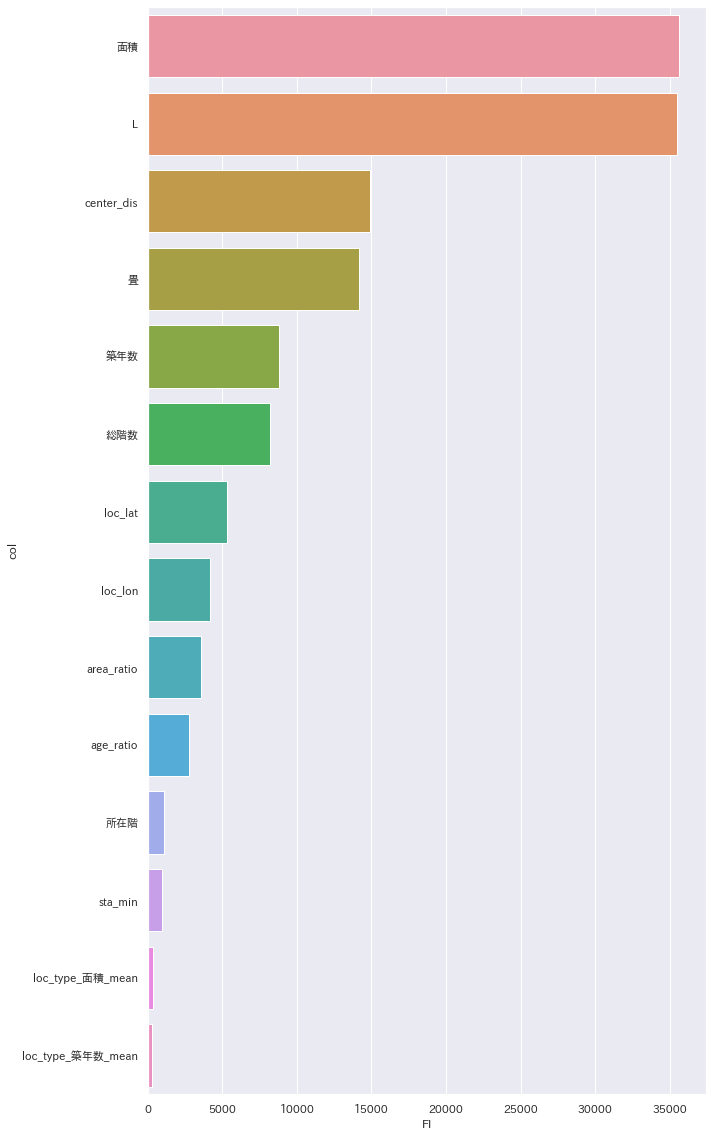

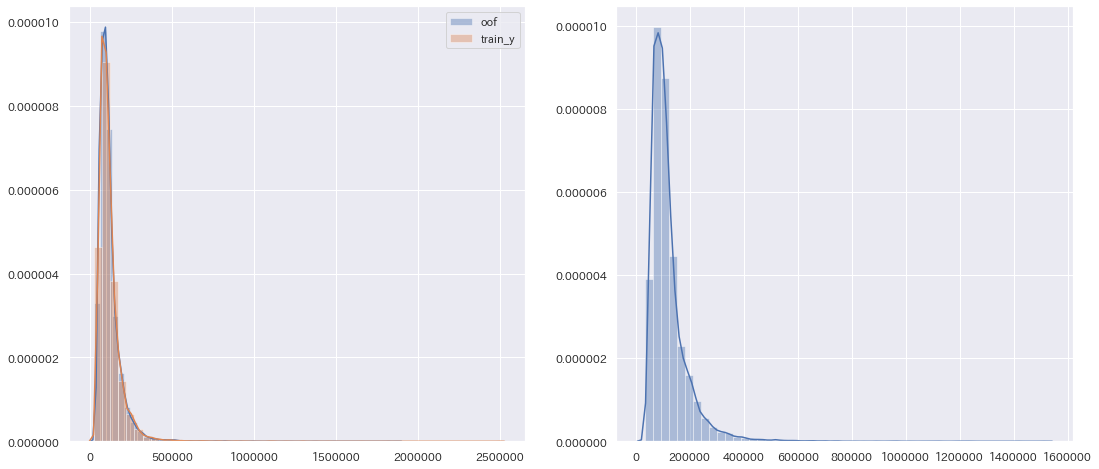

In [12]:
lgbPredictor = LogRegressionPredictor(X_train, y_train.values,  X_test,Folder=folder, params=params,
                                   sk_model=None, n_splits=3, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = lgbPredictor.fit()
lgbPredictor.plot_FI(50)
lgbPredictor.plot_pred_dist()

RMSE :  18498.918255099892
R^2 :  0.9312120354965971


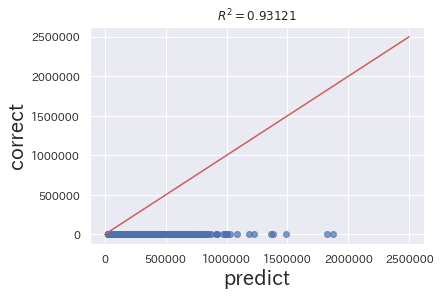

In [13]:
lgbPredictor.plot_scatter_oofvspred()

In [ ]:
from collections import Counter
from catboost import CatBoost
from catboost import Pool
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sys
from sklearn.ensemble import RandomForestRegressor
from time import time
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
'''
使い方
lgbPredictor = RegressionPredictor(train_df, train_y, test_df, params=lgbm_params,
                                   sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = lgbPredictor.fit()
lgbPredictor.plot_FI(50)
lgbPredictor.plot_pred_dist()

'''


class RegressionPredictor(object):
    '''
    回帰をKfoldで学習するクラス。
    X->dataframe,y->numpy.array
    TODO:分類、多クラス対応/Folderを外部から渡す/predictのプロット/できれば学習曲線のプロット
    '''

    def __init__(self, train_X, train_y, test_X, params=None, Folder=None, sk_model=None, n_splits=5, clf_type='xgb', aggfunc_dict=None, verbose_eval=5000):
        self.kf = Folder if Folder !=None else KFold(n_splits=n_splits, shuffle=True, random_state=42)
        self.columns = train_X.columns.values
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.verbose_eval = verbose_eval
        self.params = params
        self.aggfunc_dict = aggfunc_dict
        TE_cols = np.sum([len(x) for x in self.aggfunc_dict.values()]) if aggfunc_dict != None else 0
        self.oof = np.zeros((len(self.train_X),))
        self.preds = np.zeros((len(self.test_X),))
        if clf_type == 'xgb':
            self.FIs = {}
        else:
            self.FIs = np.zeros(self.train_X.shape[1] + TE_cols, dtype=np.float)
        self.sk_model = sk_model
        self.clf_type = clf_type
        self.aggfunc_dict = aggfunc_dict

    @staticmethod
    def merge_dict_add_values(d1, d2):
        return dict(Counter(d1) + Counter(d2))

    def rmse(self):
        return int(np.sqrt(mean_squared_error(self.oof, self.train_y)))

    def get_model(self):
        return self.model

    def target_encoding(self, tr_X, val_X, tr_y):
        '''CVとTEのfoldを同じにした。
        test,valのTEはtr_Xの情報のみで作られる。
        self.testが更新されるが、毎回のCVで上書きされる
        TODO:後からTEを取り出せるようにする。
        '''
        tr_X['target'] = tr_y
        for category_col, func_list in self.aggfunc_dict.items():
            agg_func = {'target': func_list}
            #agg_funcでgruopby
            agg_df = tr_X.groupby(category_col)['target'].agg(agg_func)
            #列名作成
            agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]

            #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
            #列名を追加する。
            if not set(agg_df.columns.values).issubset(set(self.columns)):
                self.columns = np.append(self.columns, agg_df.columns.values)
            for col in agg_df.columns.values:
                tr_X[col] = tr_X[category_col].map(agg_df[col]).copy()
                val_X[col] = val_X[category_col].map(agg_df[col]).copy()
                self.test_X[col] = self.test_X[category_col].map(agg_df[col]).copy()
        tr_X.drop(columns='target', inplace=True)
        return tr_X, val_X

    def _get_xgb_callbacks(self):
        '''nround,early_stopをparam_dictから得るためのメソッド'''
        nround = 1000
        early_stop_rounds = 10
        if self.params['num_boost_round']:
            nround = self.params['num_boost_round']
            del self.params['num_boost_round']

        if self.params['early_stopping_rounds']:
            early_stop_rounds = self.params['early_stopping_rounds']
            del self.params['early_stopping_rounds']
        return nround, early_stop_rounds

    def _get_cv_model(self, tr_X, val_X, tr_y, val_y, val_idx):

        if self.clf_type == 'cat':
            clf_train = Pool(tr_X, tr_y)
            clf_val = Pool(val_X, val_y)
            clf_test = Pool(self.test_X)
            self.model = CatBoost(params=self.params)
            self.model.fit(clf_train, eval_set=[clf_val])
            self.oof[val_idx] = self.model.predict(clf_val)
            self.preds += self.model.predict(clf_test) / self.kf.n_splits
            self.FIs += self.model.get_feature_importance()

        elif self.clf_type == 'lgb':
            clf_train = lgb.Dataset(tr_X, tr_y)
            clf_val = lgb.Dataset(val_X, val_y, reference=lgb.train)
            self.model = lgb.train(self.params, clf_train, valid_sets=[clf_train, clf_val], verbose_eval=self.verbose_eval)
            self.oof[val_idx] = self.model.predict(val_X, num_iteration=self.model.best_iteration)
            self.preds += self.model.predict(self.test_X, num_iteration=self.model.best_iteration) / self.kf.n_splits
            self.FIs += self.model.feature_importance(importance_type='gain')

        elif self.clf_type == 'xgb':
            clf_train = xgb.DMatrix(tr_X, label=tr_y, feature_names=self.columns)
            clf_val = xgb.DMatrix(val_X, label=val_y, feature_names=self.columns)
            clf_test = xgb.DMatrix(self.test_X, feature_names=self.columns)
            evals = [(clf_train, 'train'), (clf_val, 'eval')]
            evals_result = {}

            nround, early_stop_rounds = self._get_xgb_callbacks()
            self.model = xgb.train(self.params,
                                   clf_train,
                                   num_boost_round=nround,
                                   early_stopping_rounds=early_stop_rounds,
                                   evals=evals,
                                   evals_result=evals_result)

            self.oof[val_idx] = self.model.predict(clf_val)
            self.preds += self.model.predict(clf_test) / self.kf.n_splits
            self.FIs = self.merge_dict_add_values(self.FIs, self.model.get_fscore())

        elif self.clf_type == 'sklearn':
            self.model = self.sk_model
            self.model.fit(tr_X, tr_y)
            self.oof[val_idx] = self.model.predict(val_X)
            self.preds += self.model.predict(self.test_X) / self.kf.n_splits
            self.FIs += self.model.feature_importances_
        else:
            raise ValueError('clf_type is wrong.')

    def fit(self):
        start_time = time()

        for i, (train_idx, val_idx) in enumerate(self.kf.split(self.train_X, self.train_y)):

            print(f'Training on fold {i+1}')
            X_train = self.train_X.iloc[train_idx, :]
            X_val = self.train_X.iloc[val_idx, :]
            y_train = self.train_y[train_idx]
            y_val = self.train_y[val_idx]
            if self.aggfunc_dict != None:
                X_train, X_val = self.target_encoding(X_train, X_val, y_train)
            self._get_cv_model(X_train, X_val, y_train, y_val, val_idx)

        print('-' * 30)
        print('Training has finished.')
        print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - start_time))))
        print('-' * 30)
        print('this self.model`s rmse:', self.rmse())

        return self.oof, self.preds, self.FIs

    def plot_FI(self, max_row=50):
        plt.figure(figsize=(10, 20))
        if self.clf_type == 'xgb':
            df = pd.DataFrame.from_dict(self.FIs, orient='index').reset_index()
            df.columns = ['col', 'FI']
        else:
            df = pd.DataFrame({'FI': self.FIs, 'col': self.columns})
        df = df.sort_values('FI', ascending=False).reset_index(drop=True).iloc[:max_row, :]
        sns.barplot(x='FI', y='col', data=df)
        plt.show()

    def plot_pred_dist(self):
        fig, axs = plt.subplots(1, 2, figsize=(18, 8))
        sns.distplot(self.oof, ax=axs[1], label='oof')
        sns.distplot(self.train_y, ax=axs[0], label='train_y')
        sns.distplot(self.preds, ax=axs[0], label='test_preds')
        plt.show()
    
    def plot_scatter_oofvspred(self):
        print('RMSE : ', np.sqrt(mean_squared_error(self.oof, self.preds)))
        print('R^2 : ', r2_score(self.oof, self.preds))
        plt.figure()
        plt.scatter(self.oof, self.preds, alpha=0.7)
        plt.title("$R^2 = {:<.5}$".format(r2_score(self.oof, self.preds)))
        x = np.linspace(0, 2500000, 100)
        plt.plot(x, x, c="indianred")
        plt.xlabel('predict', size=20)
        plt.ylabel('correct', size=20)


class LogRegressionPredictor(RegressionPredictor):
    '''学習時に目的変数を変換するときに使う。例えばlogを取ってから学習する場合など。
         revertには逆操作となる関数を定義する。    
    '''
    def __init__(self, train_X, train_y, test_X, params=None, Folder=None, sk_model=None, n_splits=5, clf_type='xgb', aggfunc_dict=None, verbose_eval=5000, func=np.log1p, revert_func=np.expm1):
        self.func=func
        self.revert_func=revert_func
        super(LogRegressionPredictor, self).__init__(train_X, self.func(train_y), test_X, params,
                                                     Folder, sk_model, n_splits, clf_type, aggfunc_dict, verbose_eval)

    def _get_cv_model(self, tr_X, val_X, tr_y, val_y, val_idx):

        if self.clf_type == 'cat':
            clf_train = Pool(tr_X, tr_y)
            clf_val = Pool(val_X, val_y)
            clf_test = Pool(self.test_X)
            self.model = CatBoost(params=self.params)
            self.model.fit(clf_train, eval_set=[clf_val])
            self.oof[val_idx] = self.revert_func(self.model.predict(clf_val))
            self.preds += self.revert_func(self.model.predict(clf_test)) / self.kf.n_splits
            self.FIs += self.model.get_feature_importance()

        elif self.clf_type == 'lgb':
            clf_train = lgb.Dataset(tr_X, tr_y)
            clf_val = lgb.Dataset(val_X, val_y, reference=lgb.train)
            self.model = lgb.train(self.params, clf_train, valid_sets=[
                                   clf_train, clf_val], verbose_eval=self.verbose_eval)
            self.oof[val_idx] = self.revert_func(self.model.predict(val_X, num_iteration=self.model.best_iteration))
            self.preds += self.revert_func(self.model.predict(self.test_X, num_iteration=self.model.best_iteration)) / self.kf.n_splits
            self.FIs += self.model.feature_importance(importance_type='gain')

        elif self.clf_type == 'xgb':
            clf_train = xgb.DMatrix(tr_X, label=tr_y, feature_names=self.columns)
            clf_val = xgb.DMatrix(val_X, label=val_y, feature_names=self.columns)
            clf_test = xgb.DMatrix(self.test_X, feature_names=self.columns)
            evals = [(clf_train, 'train'), (clf_val, 'eval')]
            evals_result = {}

            nround, early_stop_rounds = self._get_xgb_callbacks()
            self.model = xgb.train(self.params,
                                   clf_train,
                                   num_boost_round=nround,
                                   early_stopping_rounds=early_stop_rounds,
                                   evals=evals,
                                   evals_result=evals_result)

            self.oof[val_idx] = self.revert_func(self.model.predict(clf_val))
            self.preds += self.revert_func(self.model.predict(clf_test)) / self.kf.n_splits
            self.FIs = self.merge_dict_add_values(self.FIs, self.model.get_fscore())

        elif self.clf_type == 'sklearn':
            self.model = self.sk_model
            self.model.fit(tr_X, tr_y)
            self.oof[val_idx] = self.revert_func(self.model.predict(val_X))
            self.preds += self.revert_func(self.model.predict(self.test_X)) / self.kf.n_splits
            self.FIs += self.model.feature_importances_
        else:
            raise ValueError('clf_type is wrong.')


In [77]:
kf = KFold(n_splits=n_splits, random_state=SEED)

rmses = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
predictions = pd.DataFrame({'id':list(test.id.values)})
oof = pd.DataFrame({'id':list(train.id.values),'y_train':list(y_train.values)})
training_start_time = time()

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    tr_x, tr_y = X_train.iloc[trn_idx], y_train_log.iloc[trn_idx]
    vl_x, vl_y = X_train.iloc[val_idx], y_train_log.iloc[val_idx]
    print(len(tr_x), len(vl_y))
    
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    clf = lgb.train(params, tr_data, 5000, valid_sets = [tr_data, vl_data], verbose_eval=500, early_stopping_rounds=20)
    oof.loc[val_idx,'oof'] = np.expm1(clf.predict(vl_x, num_iteration=clf.best_iteration))
    
    ## アンサンブル
    print('start predict')
    pred = clf.predict(X_test)
    predictions['pred'+str(fold)] = np.expm1(pred)
 
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance('gain')
    rmses.append(clf.best_score['valid_1']['l1'])
    
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
    gc.collect()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean RMSE:', np.mean(rmses))
print('-' * 30)

feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for kf in range(kf.n_splits)]].mean(axis=1)



Training on fold 1
28320 3147
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0613604	valid_1's l1: 0.0711576
[1000]	training's l1: 0.0524487	valid_1's l1: 0.0675438
[1500]	training's l1: 0.0463314	valid_1's l1: 0.0656304
[2000]	training's l1: 0.0415242	valid_1's l1: 0.0643738
[2500]	training's l1: 0.0375974	valid_1's l1: 0.0633469
[3000]	training's l1: 0.0342662	valid_1's l1: 0.0625553
[3500]	training's l1: 0.0314402	valid_1's l1: 0.0618835
[4000]	training's l1: 0.0289113	valid_1's l1: 0.0612907
[4500]	training's l1: 0.026682	valid_1's l1: 0.0608572
[5000]	training's l1: 0.0247881	valid_1's l1: 0.0605144
[5500]	training's l1: 0.0230524	valid_1's l1: 0.0601915
Early stopping, best iteration is:
[5669]	training's l1: 0.0225269	valid_1's l1: 0.0600907
start predict
Fold 1 finished in 0:00:05.862995
Training on fold 2
28320 3147
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0614513	valid_1's l1: 0.0702353
[1000]	t

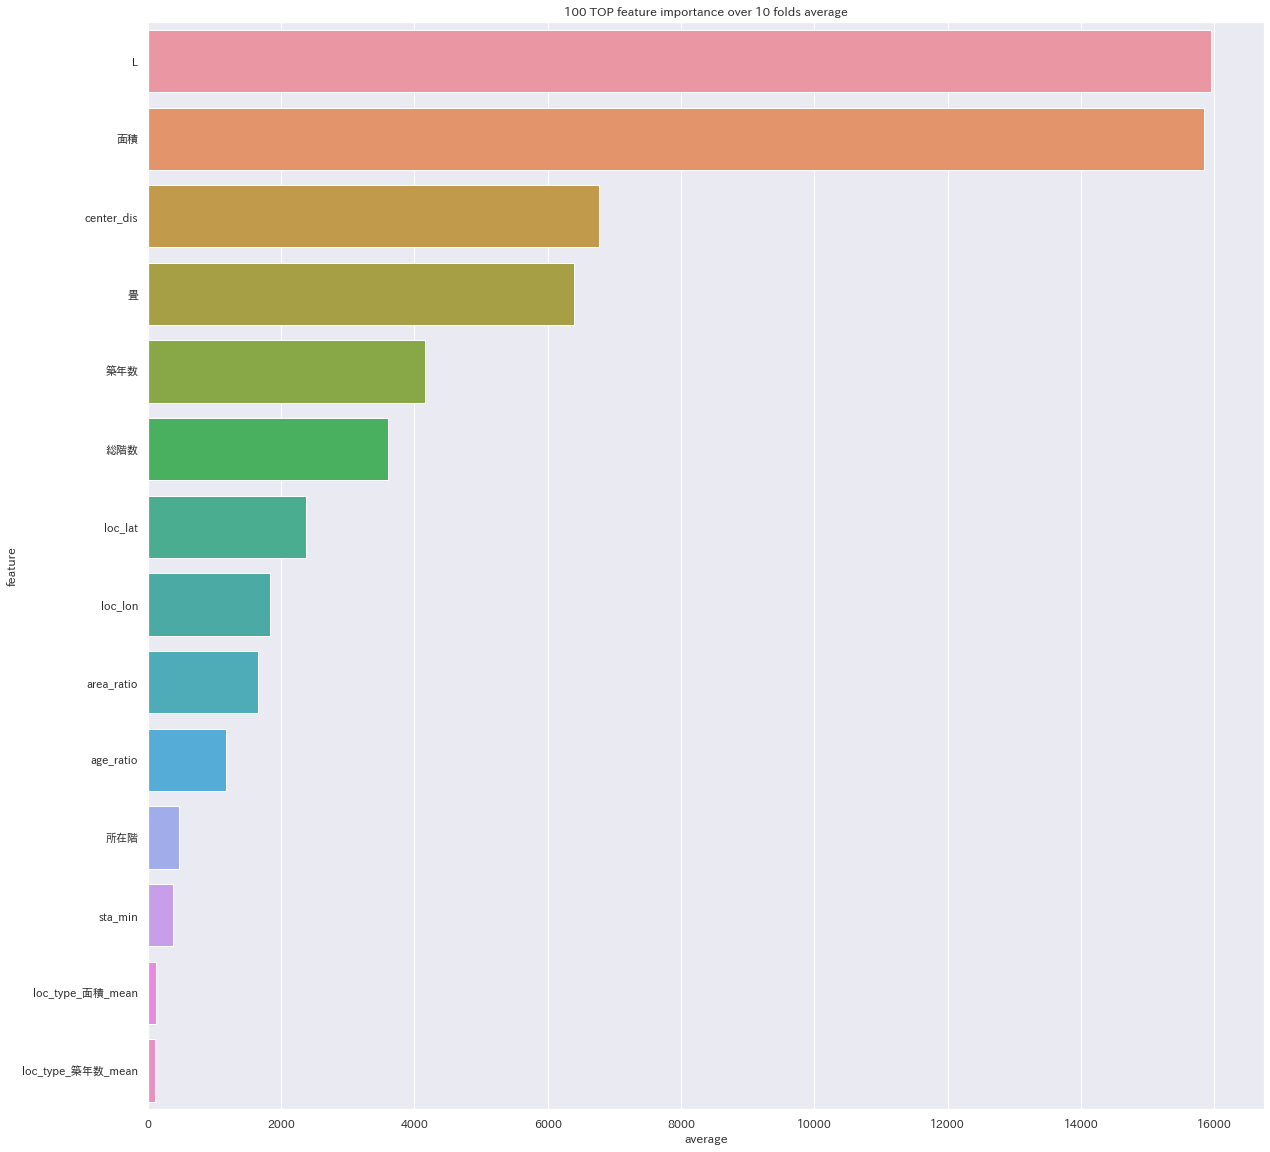

In [78]:
plt.figure(figsize=(20, 20))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over {} folds average'.format(kf.n_splits))
plt.show()


RMSE :  17762.91018276366
R^2 :  0.9360987136923908


Text(0, 0.5, 'correct')

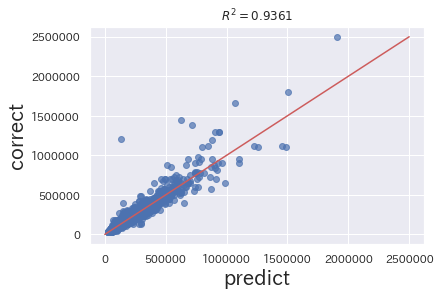

In [79]:
#validationのずれを確認する
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('RMSE : ',np.sqrt(mean_squared_error(oof['oof'], oof['y_train'])))
print('R^2 : ',r2_score(oof['oof'], oof['y_train']))
plt.figure()
plt.scatter(oof['oof'], oof['y_train'], alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(oof['oof'], oof['y_train'])))
x = np.linspace(0, 2500000, 100)
plt.plot(x, x, c="indianred")
plt.xlabel('predict',size=20)
plt.ylabel('correct',size=20)